In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import os

# Ścieżki do plików
pomiar_path = './dataset_pv_v2/dane_03-06_cleaned.xlsx'
forecast_files = [os.path.join('./dataset_pv_cleaned', f) for f in os.listdir('./dataset_pv_cleaned') if f.endswith('_cleaned.xlsx')]




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\nahyb\AppData\Local\Programs\Python\Python311\Lib\runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\nahyb\AppData\Local\Programs\Python\Python311\Lib\runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "C:\Users\nahyb\nbeats_env\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\nahyb\nbeats_env\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\nahyb\AppData\Local\Programs\Python\Python311\Lib\runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\nahyb\AppData\Local\Programs\Python\Python311\Lib\runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "C:\Users\nahyb\nbeats_env\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\nahyb\nbeats_env\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

AttributeError: _ARRAY_API not found

In [16]:
# 1. Wczytanie danych pomiarowych
dane_pomiarowe = pd.read_excel(pomiar_path)
dane_pomiarowe['timestamp'] = pd.to_datetime(dane_pomiarowe['Data'] + ' ' + dane_pomiarowe['Czas'], errors='coerce')
num_columns = ['PV1_Pd', 'PV2_Wsch', 'PV3_Zach', 'PV4_Wsch']
for col in num_columns:
    dane_pomiarowe[col] = pd.to_numeric(dane_pomiarowe[col], errors='coerce')
dane_pomiarowe = dane_pomiarowe[['timestamp'] + num_columns]
pomiar_30min = dane_pomiarowe.resample('30min', on='timestamp').mean().reset_index()

# Usunięcie stref czasowych
pomiar_30min['timestamp'] = pomiar_30min['timestamp'].dt.tz_localize(None)



In [17]:
# 2. Wczytanie i łączenie danych prognozowych
dane_prognozy = pd.DataFrame()
for file in forecast_files:
    temp = pd.read_excel(file)
    if 'period_end' in temp.columns:
        temp['period_end'] = pd.to_datetime(temp['period_end'], errors='coerce')
    else:
        print(f"Plik {file} nie zawiera kolumny 'period_end'. Pomijanie.")
        continue
    temp = temp.dropna(subset=['period_end'])
    temp['period_end'] = temp['period_end'].dt.tz_localize(None)
    dane_prognozy = pd.concat([dane_prognozy, temp], ignore_index=True)

kluczowe_kolumny = ['period_end', 'ghi10', 'dni', 'cloud_opacity', 'air_temp']
prognozy_30min = dane_prognozy[kluczowe_kolumny]
prognozy_30min = prognozy_30min.rename(columns={'ghi10': 'ghi'})


Plik ./dataset_pv_cleaned\P4_2024-05-15 02-00-10_cleaned.xlsx nie zawiera kolumny 'period_end'. Pomijanie.
Plik ./dataset_pv_cleaned\P4_2024-05-31 06-00-10_cleaned.xlsx nie zawiera kolumny 'period_end'. Pomijanie.


In [18]:
# 3. Połączenie danych pomiarowych z prognozami
polaczone_dane = pd.merge_asof(
    pomiar_30min.sort_values('timestamp'),
    prognozy_30min.sort_values('period_end'),
    left_on='timestamp',
    right_on='period_end'
)
polaczone_dane = polaczone_dane.drop(columns=['period_end'])


In [19]:
# 4. Przygotowanie danych do modelu N-BEATS
class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_size, target_col):
        self.input_size = input_size
        self.data = data
        self.target_col = target_col

    def __len__(self):
        return len(self.data) - self.input_size

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.input_size, :]
        y = self.data[idx+self.input_size, self.target_col]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Funkcja denormalizująca
def denormalize(scaled, scaler, index):
    scale = scaler.scale_[index]
    min_ = scaler.min_[index]
    return scaled * scale + min_


Modelowanie dla kolumny: PV1_Pd
Epoch 1, Loss: 0.062327981262017836
Epoch 2, Loss: 0.015594715741724613
Epoch 3, Loss: 0.012515050098770873
Epoch 4, Loss: 0.011194524950389698
Epoch 5, Loss: 0.010039808655032114
Epoch 6, Loss: 0.008889720318681989
Epoch 7, Loss: 0.008149256747938023
Epoch 8, Loss: 0.008331377833579363
Epoch 9, Loss: 0.007922461234148215
Epoch 10, Loss: 0.00878238649986517


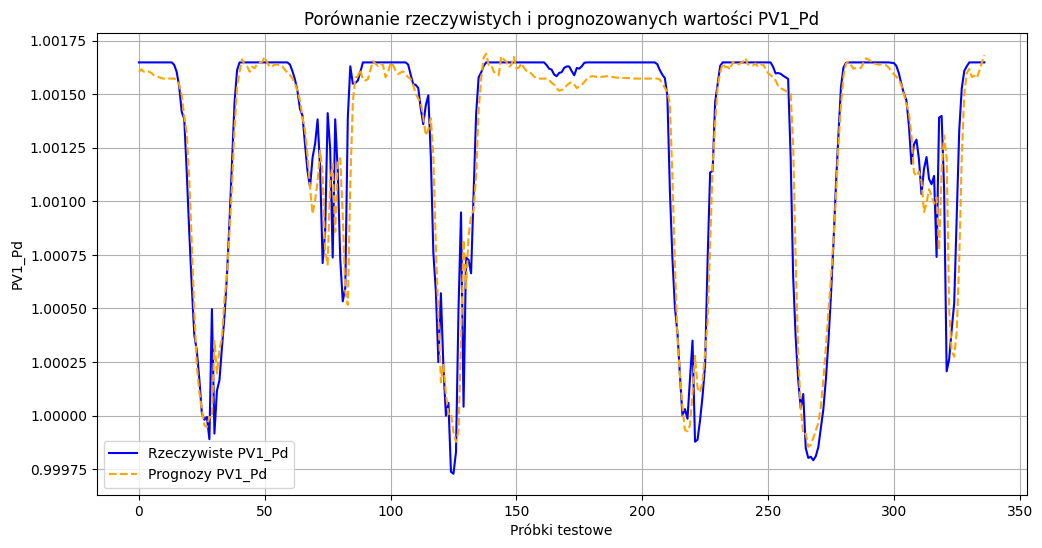

Generowanie prognozy na kolejny miesiąc dla kolumny: PV1_Pd


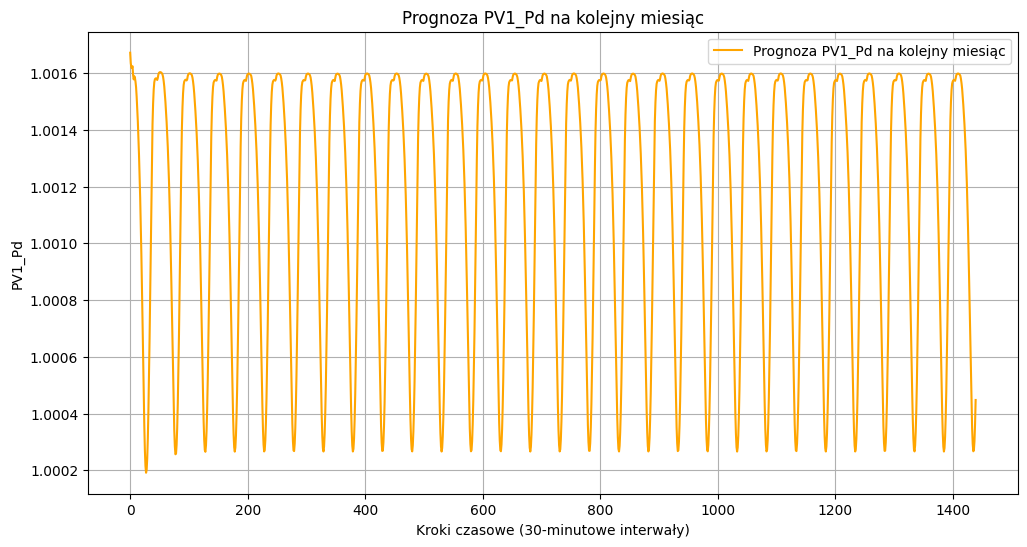

Modelowanie dla kolumny: PV2_Wsch
Epoch 1, Loss: 0.07664373457389936
Epoch 2, Loss: 0.014363693771883845
Epoch 3, Loss: 0.009423711740024638
Epoch 4, Loss: 0.009058815934642982
Epoch 5, Loss: 0.008054574143162437
Epoch 6, Loss: 0.006564690479668632
Epoch 7, Loss: 0.006365018241431857
Epoch 8, Loss: 0.0057728332316952895
Epoch 9, Loss: 0.005477657728027971
Epoch 10, Loss: 0.005553784626509911


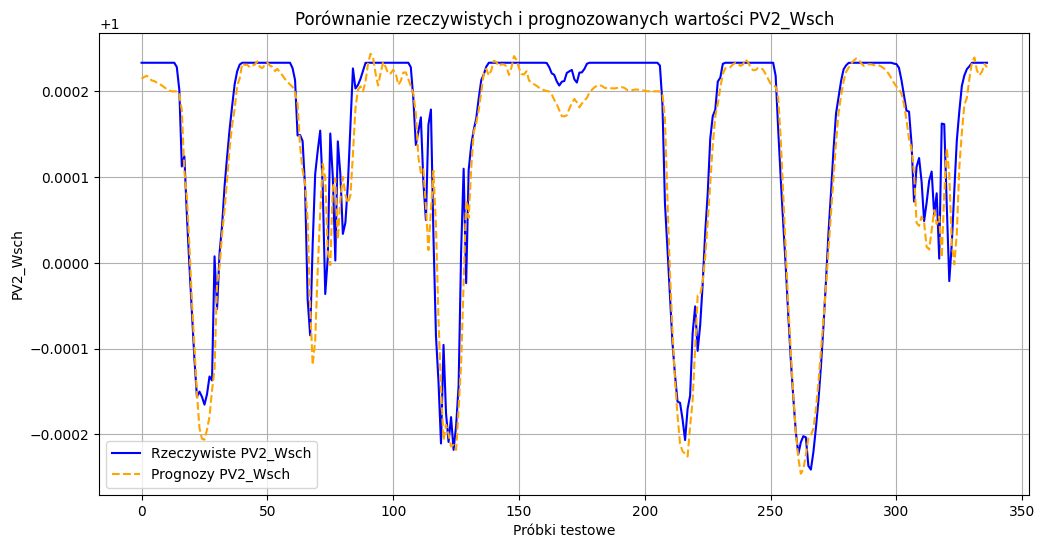

Generowanie prognozy na kolejny miesiąc dla kolumny: PV2_Wsch


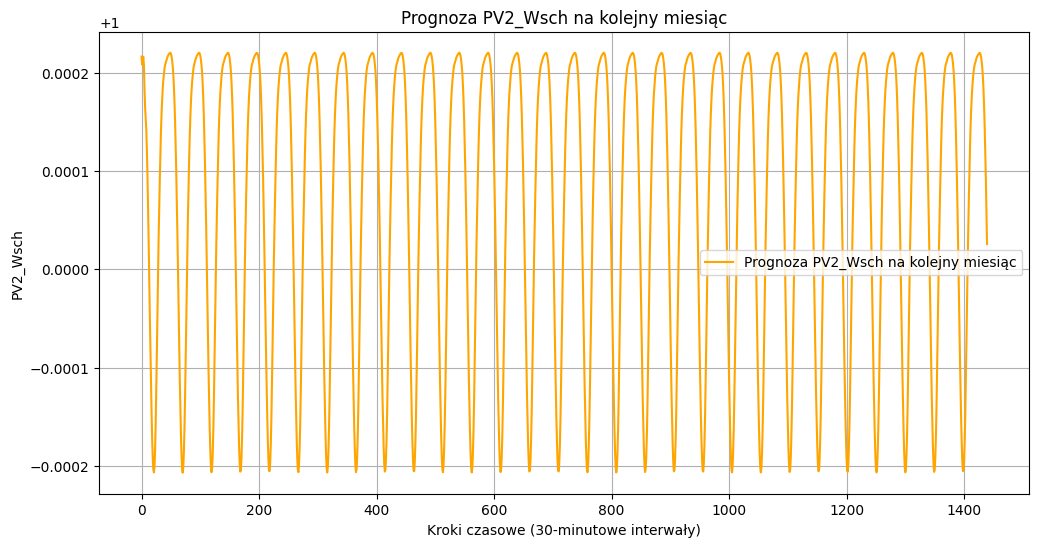

Modelowanie dla kolumny: PV3_Zach
Epoch 1, Loss: 0.07774554829249221
Epoch 2, Loss: 0.017673037020133786
Epoch 3, Loss: 0.010979636901926793
Epoch 4, Loss: 0.008540390668897314
Epoch 5, Loss: 0.008634545052884503
Epoch 6, Loss: 0.00697888593317606
Epoch 7, Loss: 0.007204687025324766
Epoch 8, Loss: 0.006172030721398677
Epoch 9, Loss: 0.006716102285158894
Epoch 10, Loss: 0.006895018871638171


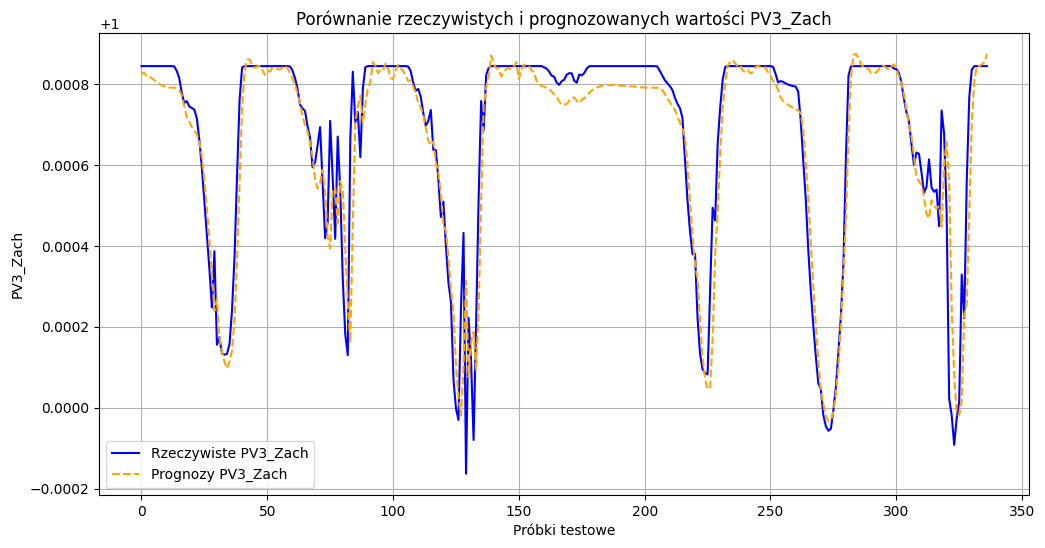

Generowanie prognozy na kolejny miesiąc dla kolumny: PV3_Zach


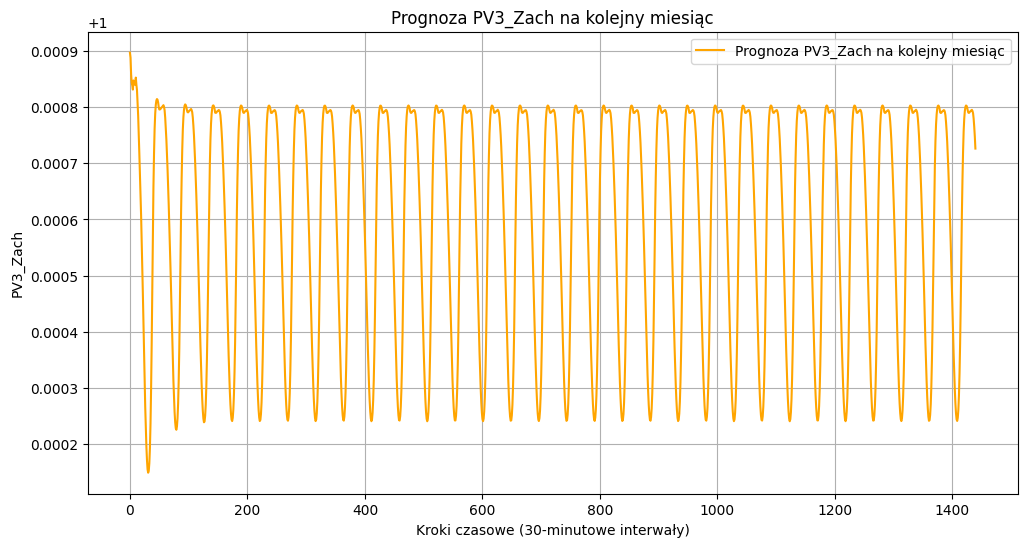

Modelowanie dla kolumny: PV4_Wsch
Epoch 1, Loss: 0.08785436554351465
Epoch 2, Loss: 0.016462405221379792
Epoch 3, Loss: 0.012578054842685631
Epoch 4, Loss: 0.009756186656559702
Epoch 5, Loss: 0.009388009823984309
Epoch 6, Loss: 0.00806673673462918
Epoch 7, Loss: 0.007581437937915325
Epoch 8, Loss: 0.006755889769449955
Epoch 9, Loss: 0.006856335173334843
Epoch 10, Loss: 0.007433798096765335


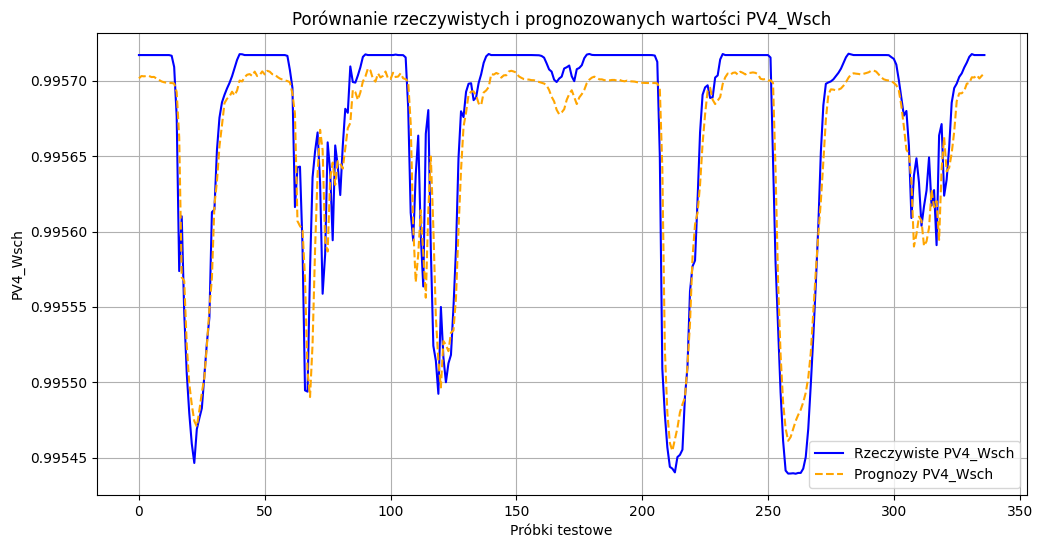

Generowanie prognozy na kolejny miesiąc dla kolumny: PV4_Wsch


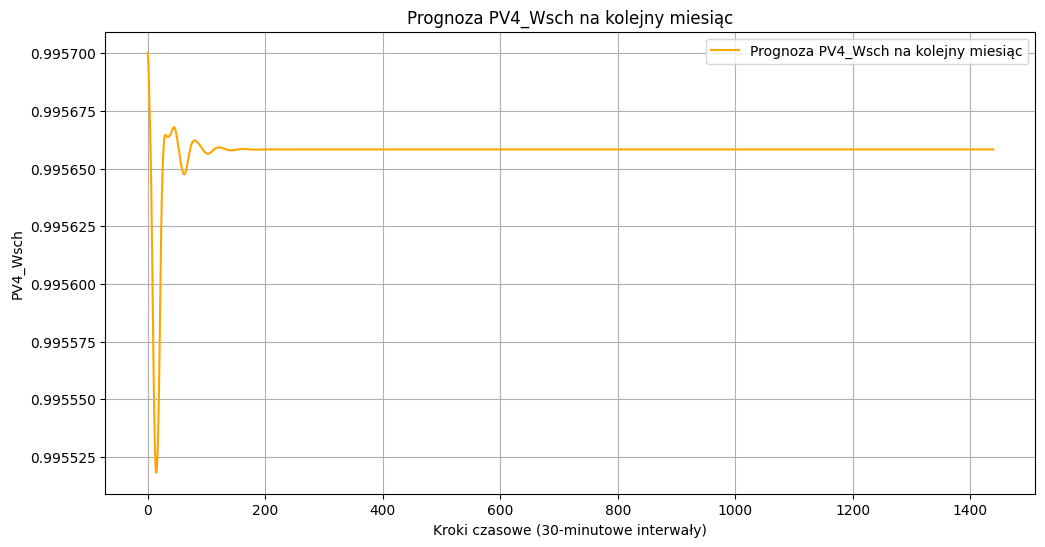

In [20]:
# Generowanie prognozy i porównanie rzeczywistych z prognozowanymi
for target_idx, target_col in enumerate(num_columns):
    print(f"Modelowanie dla kolumny: {target_col}")

    # Skalowanie danych
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(polaczone_dane[[target_col, 'ghi', 'dni', 'cloud_opacity', 'air_temp']].dropna())

    # Podział danych
    input_size = 24
    train_data, test_data = train_test_split(data_scaled, test_size=0.2, shuffle=False)
    train_dataset = TimeSeriesDataset(train_data, input_size, target_col=0)
    test_dataset = TimeSeriesDataset(test_data, input_size, target_col=0)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Budowa modelu
    class NBeatsBlock(nn.Module):
        def __init__(self, input_size, output_size):
            super().__init__()
            self.fc = nn.Sequential(
                nn.Linear(input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, output_size)
            )

        def forward(self, x):
            return self.fc(x)

    model = NBeatsBlock(input_size=input_size * 5, output_size=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # Trenowanie modelu
    for epoch in range(10):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x = x.view(x.size(0), -1)
            y_pred = model(x)
            loss = loss_fn(y_pred.squeeze(), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader)}')

    # Porównanie rzeczywistych i prognozowanych
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.view(x.size(0), -1)
            y_pred = model(x).squeeze()
            predictions.extend(y_pred.cpu().numpy().flatten().tolist())
            true_values.extend(y.cpu().numpy().flatten().tolist())

    # Denormalizacja wyników
    predictions_denorm = denormalize(np.array(predictions), scaler, 0)
    true_values_denorm = denormalize(np.array(true_values), scaler, 0)

    # Tworzenie wykresu rzeczywistych i prognozowanych
    plt.figure(figsize=(12, 6))
    plt.plot(true_values_denorm, label=f"Rzeczywiste {target_col}", color="blue")
    plt.plot(predictions_denorm, label=f"Prognozy {target_col}", color="orange", linestyle="--")
    plt.xlabel("Próbki testowe")
    plt.ylabel(target_col)
    plt.title(f"Porównanie rzeczywistych i prognozowanych wartości {target_col}")
    plt.legend()
    plt.grid()
    plt.show()

    # Prognoza na kolejny miesiąc
    print(f"Generowanie prognozy na kolejny miesiąc dla kolumny: {target_col}")
    future_predictions = []
    last_data = data_scaled[-input_size:, :]  # Ostatnie dane jako początek prognozy

    with torch.no_grad():
        for _ in range(30 * 48):  # Prognoza na 30 dni (48 półgodzinnych kroków)
            input_tensor = torch.tensor(last_data.flatten(), dtype=torch.float32).unsqueeze(0)
            future_pred = model(input_tensor).item()
            future_predictions.append(future_pred)
            last_data = np.roll(last_data, -1, axis=0)
            last_data[-1, 0] = future_pred
            last_data[-1, 1:] = last_data[-2, 1:]

    # Denormalizacja prognoz
    future_predictions_denorm = denormalize(np.array(future_predictions), scaler, 0)

    # Tworzenie wykresu prognozy na miesiąc
    plt.figure(figsize=(12, 6))
    plt.plot(future_predictions_denorm, label=f"Prognoza {target_col} na kolejny miesiąc", color="orange")
    plt.xlabel("Kroki czasowe (30-minutowe interwały)")
    plt.ylabel(target_col)
    plt.title(f"Prognoza {target_col} na kolejny miesiąc")
    plt.legend()
    plt.grid()
    plt.show()
